dataset url
https://zenodo.org/records/2235448

# 1. DINOv2: Learning Robust Visual Features without Supervision
Domain Generalization	ImageNet-C	DINOv2 (ViT-S/14, frozen model, linear eval)

https://github.com/facebookresearch/dinov2

In [6]:
import torch
from PIL import Image
import torchvision.transforms as T

In [9]:
# DINOv2
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /home/xyang/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
def interpolate_to_patch_size(img_bchw, patch_size):
    # Interpolate the image so that H and W are multiples of the patch size
    _, _, H, W = img_bchw.shape
    target_H = H // patch_size * patch_size
    target_W = W // patch_size * patch_size
    img_bchw = torch.nn.functional.interpolate(img_bchw, size=(target_H, target_W))
    return img_bchw, target_H, target_W

In [12]:
img = Image.open('qian.jpg')
print(img.size)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

img = transform(img)[:3].unsqueeze(0)
print(img.shape)

img, target_H, target_W = interpolate_to_patch_size(img, dinov2.patch_size)
print(img.shape)

(859, 1144)
torch.Size([1, 3, 1144, 859])
torch.Size([1, 3, 1134, 854])


In [13]:
with torch.no_grad():
    features = dinov2.forward_features(img)["x_norm_patchtokens"][0]
    print(features.shape)

torch.Size([4941, 384])


In [14]:
features_hwc = features.reshape((target_H // dinov2.patch_size, target_W // dinov2.patch_size, -1))
features_chw = features_hwc.permute(2, 0, 1)
print(features_chw.shape)

torch.Size([384, 81, 61])


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


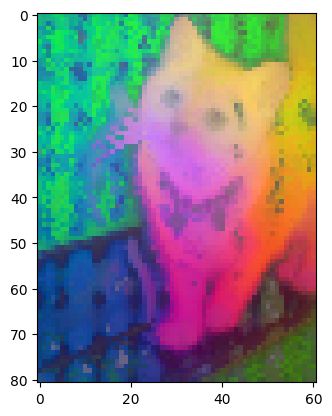

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(features)

pca_features = pca.transform(features)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

plt.imshow(pca_features.reshape(target_H // dinov2.patch_size, target_W // dinov2.patch_size, 3).astype(np.uint8))

In [ ]:
# https://github.com/roboflow/notebooks/blob/main/notebooks/dinov2-classification.ipynb
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])